# Taller de regresion - Salarios Cientificos de Datos

- Jesús Alberto Florez Lizarazo
- Lucero Zarate Herrera
- Víctor Echavarría

In [ ]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Gestion de librerias
# ==============================================================================
from importlib import reload

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split

# Matemáticas y estadísticas
# ==============================================================================
import math


#Creación de modelo
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.ensemble import GradientBoostingRegressor


#Evaluación del modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.inspection import permutation_importance
import multiprocessing

# Preparación de datos
# ==============================================================================
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Funciones

In [ ]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, tidy_corr_matrix,checkVIF

In [ ]:
# Función para contruir un modelo de regresión lineal por medio de statsmodels.api
# Datos de entrada y de salida. Va a consturir un modelo y lo va a entrenar

def build_model(X,y):

    #A los datos de entrada 'X' se le adiciona una constante
    X = sm.add_constant(X)

    #Se crea y se entrena el modelo de regresion lineal q(statsmodels.api) con
    #los datos de entrada 'X' y los datos de salida 'y'
    lm = sm.OLS(y,X).fit()

    #imprime el resumen del modelo creado
    print(lm.summary()) # model summary

    return X

In [ ]:
#Cargar el dataset
# d=pd.read_csv('/content/ds_salaries.csv') #Colab
d=pd.read_csv(r'ds_salaries.csv')

In [ ]:
# Informacion de los campos
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
# Generacion de registros aleatorios
d.sample()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
1760,2023,SE,FT,Data Scientist,182000,USD,182000,US,0,US,M


In [ ]:
# Ver cantidad de duplicados
d.duplicated().sum()


1171

In [ ]:
# eliminación de registros duplicados
d = d.drop_duplicates()

#Reiniciar el indice
d.reset_index(drop=True, inplace=True)

In [ ]:
# Cambiar remote ratio a variable categorica
d['remote_ratio'] = d['remote_ratio'].astype('category')


In [ ]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size
0,SE,FT,Principal Data Scientist,EUR,ES,100,ES,L
1,MI,CT,ML Engineer,USD,US,100,US,S


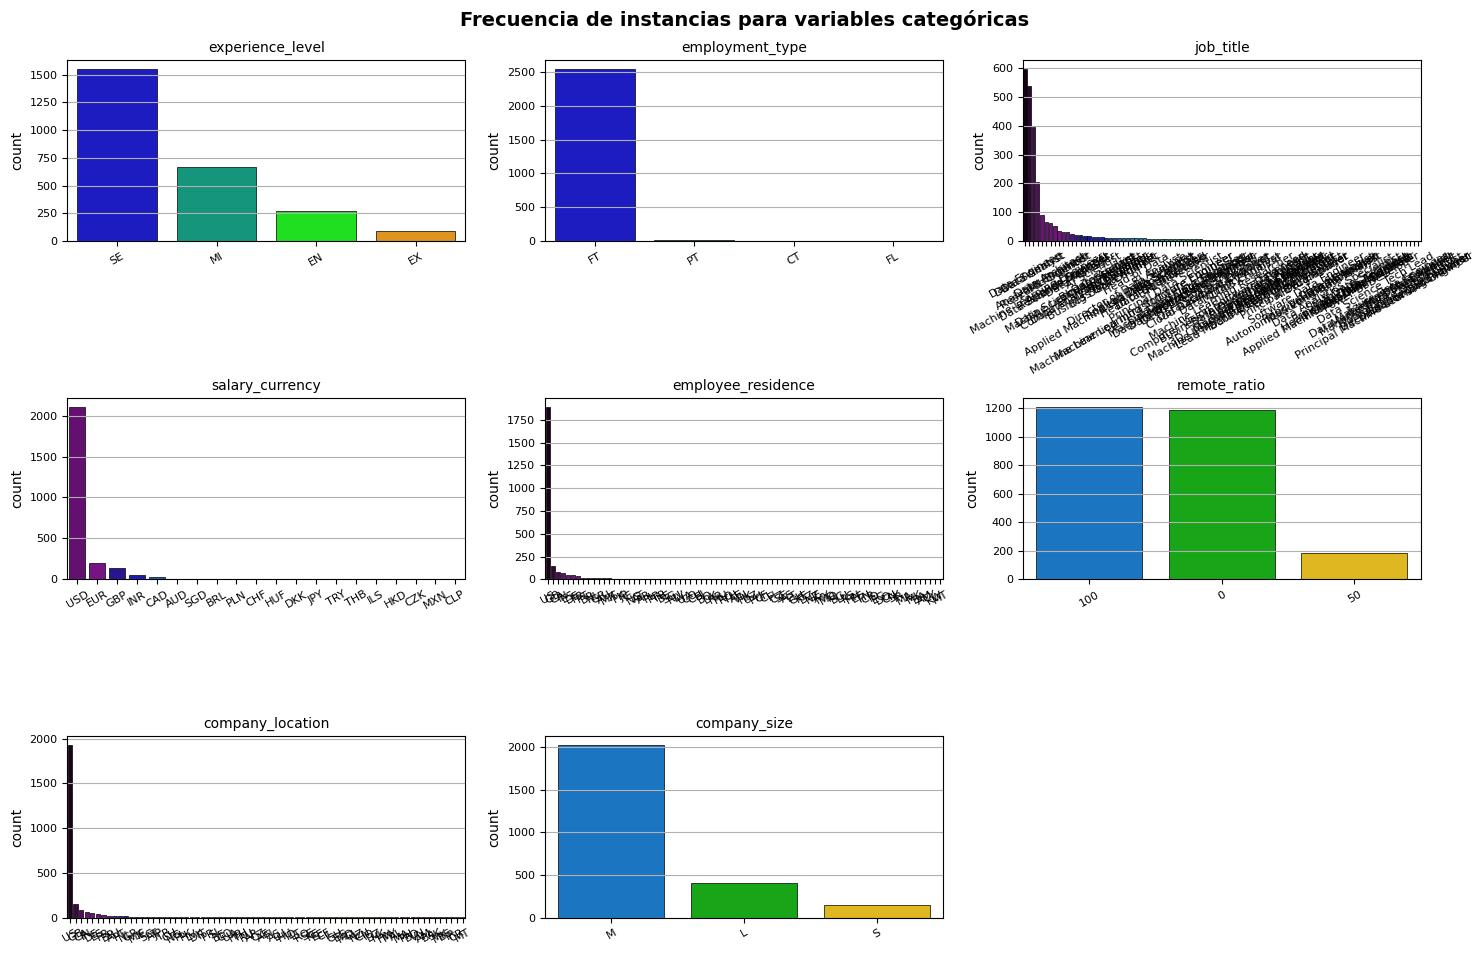

In [ ]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

Experience Level
SE : Senior.
EN : Entry level.
EX : Executive level.
MI : Mid/Intermediate level.

Employet Type
Ft and Pt are full time and part time contractor (CT) and freelancer (FL)

In [ ]:
# Distribución de cada variable categórica en el conjunto de datos

for col in catCols:
    print("="*5 + f" {col} " + "="*20)
    print(d[col].value_counts())
    print()


===== experience_level ====================
experience_level
SE    1554
MI     664
EN     270
EX      96
Name: count, dtype: int64

===== employment_type ====================
employment_type
FT    2547
PT      17
CT      10
FL      10
Name: count, dtype: int64

===== job_title ====================
job_title
Data Engineer                598
Data Scientist               538
Data Analyst                 396
Machine Learning Engineer    206
Analytics Engineer            91
                            ... 
Compliance Data Analyst        1
Deep Learning Researcher       1
Staff Data Analyst             1
Data DevOps Engineer           1
Finance Data Analyst           1
Name: count, Length: 93, dtype: int64

===== salary_currency ====================
salary_currency
USD    2107
EUR     200
GBP     144
INR      59
CAD      25
AUD       9
SGD       6
BRL       6
PLN       5
CHF       4
HUF       3
DKK       3
JPY       3
TRY       3
THB       2
ILS       1
HKD       1
CZK       1
MXN       1
CL

### Limpieza titulos de trabajo con Modelo de clasificación

In [ ]:
# Títulos de los puestos
titulos = d['job_title'].unique()
# Número de clusters
num_clusters =22

# Vectorizar los títulos
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(titulos)

# Aplicar K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Obtener las etiquetas de los clusters
labels = kmeans.labels_

# Imprimir los clusters
for i in range(num_clusters):
    print(f"Cluster {i}:")
    for j, titulo in enumerate(titulos):
        if labels[j] == i:
            print(f"- {titulo}")
    print()

Cluster 0:
- Principal Data Scientist
- Principal Data Analyst
- Principal Data Engineer

Cluster 1:
- Machine Learning Engineer
- Applied Machine Learning Engineer
- Machine Learning Researcher
- Machine Learning Scientist
- Machine Learning Infrastructure Engineer
- Machine Learning Software Engineer
- Machine Learning Research Engineer
- Machine Learning Developer
- Principal Machine Learning Engineer
- Machine Learning Manager
- Lead Machine Learning Engineer

Cluster 2:
- Data Science Manager
- Director of Data Science
- Data Science Lead
- Data Science Consultant
- Data Science Engineer
- Data Science Tech Lead

Cluster 3:
- Data Specialist
- Data Analytics Specialist
- Data Management Specialist

Cluster 4:
- Data Architect
- Big Data Architect
- Principal Data Architect
- Cloud Data Architect

Cluster 5:
- Data Analyst
- Data Quality Analyst
- Compliance Data Analyst
- Business Data Analyst
- Staff Data Analyst
- Lead Data Analyst
- Financial Data Analyst
- Insight Analyst
- Pr

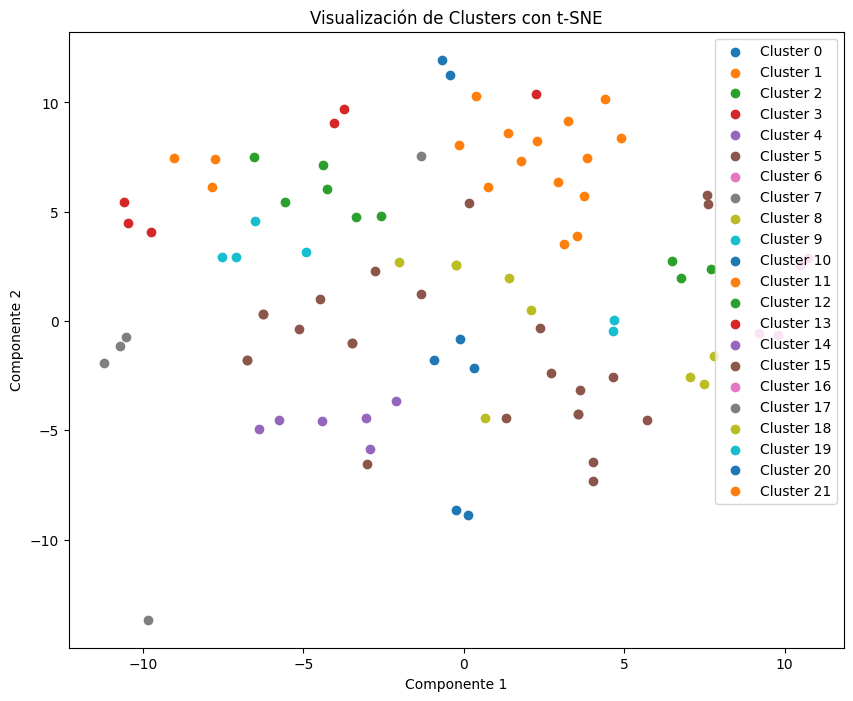

In [ ]:
# Crear visualizacion de los cluster
# # Reduce la dimensionalidad de los datos a 2 dimensiones utilizando t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

# Grafica los puntos en un gráfico de dispersión, coloreando cada punto según su etiqueta de cluster
plt.figure(figsize=(10, 8))
for i in range(num_clusters):
    plt.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1], label=f'Cluster {i}')
plt.title('Visualización de Clusters con t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend()
plt.show()

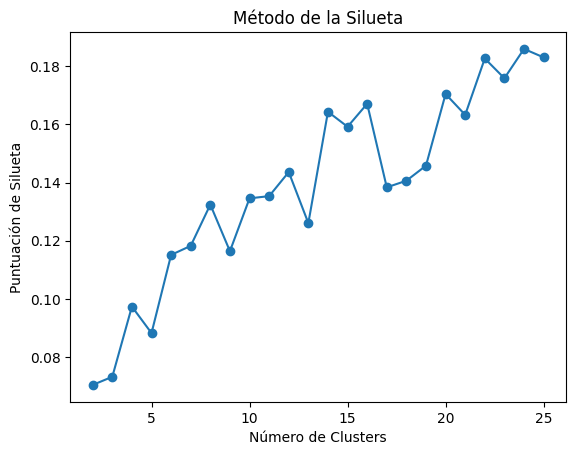

In [ ]:
# Calcular coeficiente de silueta
# Lista para almacenar los valores de silueta
silhouette_scores = []

# Número máximo de clusters a probar
max_clusters = 25

for k in range(2, max_clusters+1):
    # Inicializar y ajustar el modelo de clustering
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)

    # Calcular el coeficiente de silueta
    silhouette_avg = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

# Graficar los resultados
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Número de Clusters')
plt.ylabel('Puntuación de Silueta')
plt.title('Método de la Silueta')
plt.show()

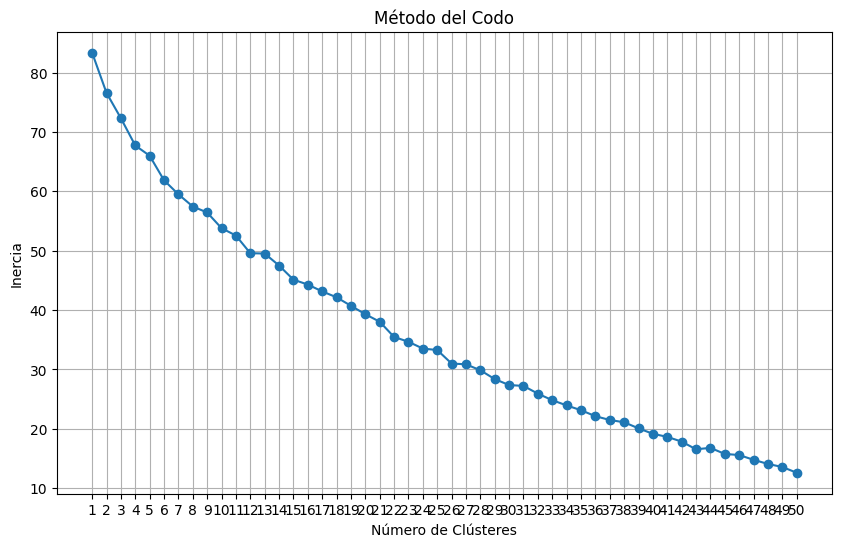

In [ ]:
# Número máximo de clústeres a probar
max_clusters = 50

# Inicializa una lista vacía para almacenar las inercias
inercias = []

# Calcula la inercia para diferentes números de clústeres
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    inercias.append(kmeans.inertia_)

# Grafica la curva de codo
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inercias, marker='o', linestyle='-')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('Inercia')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

En este caso el método de la sielueta y del codo no nos da una claridad respecto al número optimo de cluster a utilizar, adicional en la silueta nos muestra que un posible valor optimo es un número de cluster demasiado de alto que no asemeja a lo que se quiere realizar en este analisis, por lo que se descarta y se realizara através de otro método.

In [ ]:
# Homologación de categorías Cientificos de Datos, Ingenieros de Datos y Analistas de Datos. Los añade a una nueva columna
d['abv_job'] = d['job_title'].apply(lambda x: 'Data Scientist' if 'Data Scientist' in x else ('Data Engineer' if 'Data Engineer' in x else ('Data Analyst' if 'Data Analyst' in x else 'Others')))


In [ ]:
# Homologación de categorías US e International. Los añade a una nueva columna
d['abv_company_location'] = np.where(d['company_location'] == 'US', 'US', 'International')
# d['abv_employee_residence'] = np.where(d['employee_residence'] == 'US', 'US', 'International')
# d['abv_salary_currency'] = np.where(d['salary_currency'] == 'USD', 'USD', 'Others')

# Diccionario con definiciones de las variables remote radio
mapping = {100: "Full remote", 50: "Hybrid", 0: "In Office"}

# Aplicar el mapeo a la columna "remote_radio"
d["abv_remote_ratio"] = d["remote_ratio"].map(mapping)



In [ ]:
d.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,abv_job,abv_company_location,abv_remote_ratio
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,Data Scientist,International,Full remote
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,Others,US,Full remote
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,Others,US,Full remote
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,Data Scientist,International,Full remote
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,Data Scientist,International,Full remote


In [ ]:
# Obtener la cantidad de instancias por cada valor de la variable abv_job
d['abv_job'].value_counts()


abv_job
Others            944
Data Engineer     625
Data Scientist    569
Data Analyst      446
Name: count, dtype: int64

### Variables Númericas

In [ ]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
d[numCols].head()

,work_year,salary,salary_in_usd
0,2023,80000,85847
1,2023,30000,30000
2,2023,25500,25500
3,2023,175000,175000
4,2023,120000,120000


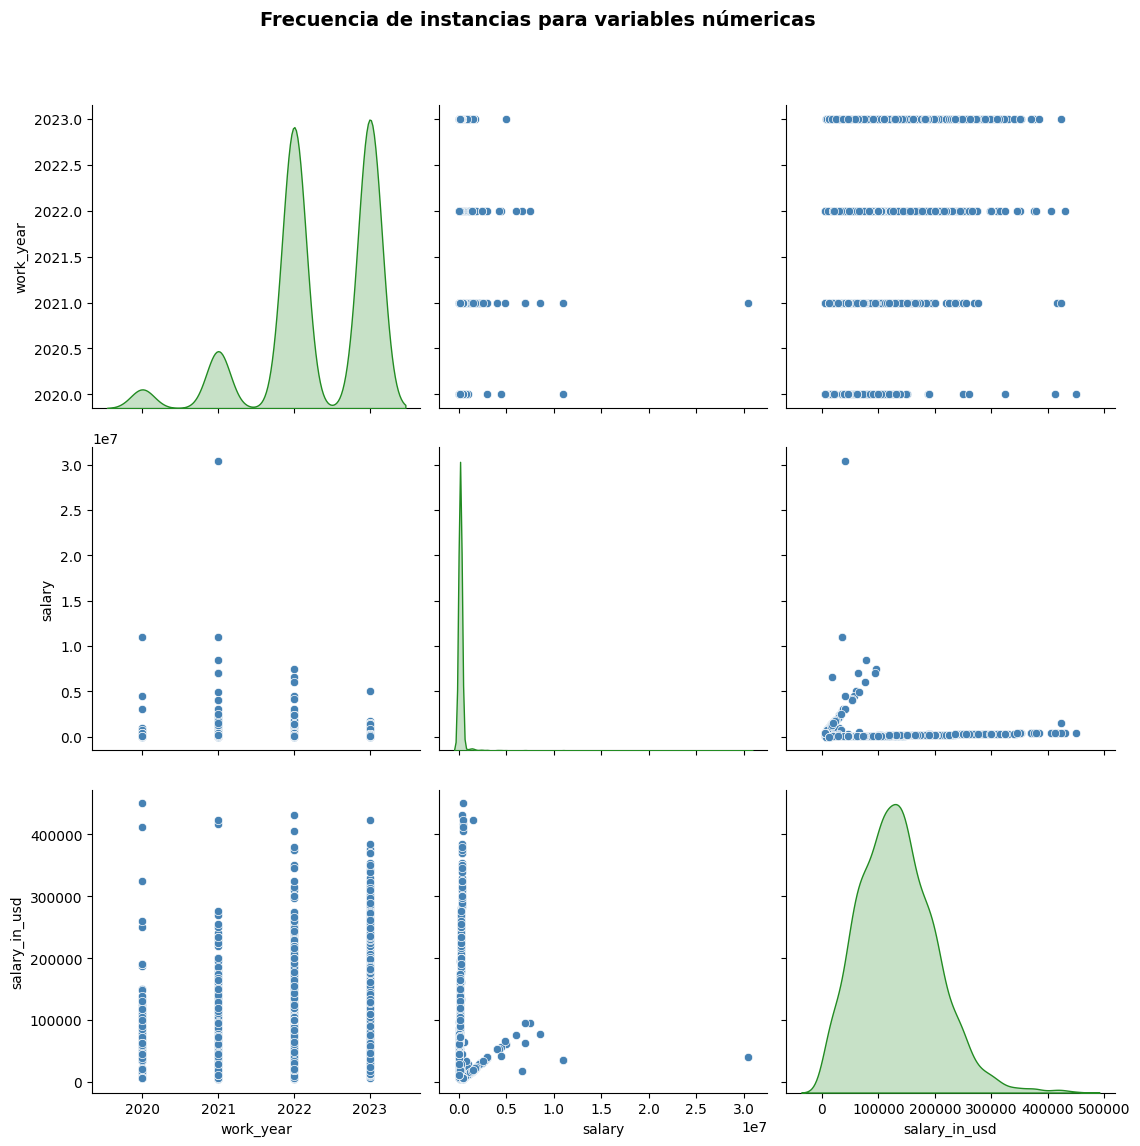

In [ ]:
#Visualización de frecuencia de instancias para variables númericas
multiple_plot(3, d , numCols, None, 'scatterplot', 'Frecuencia de instancias para variables númericas',30)

In [ ]:
d.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,abv_job,abv_company_location,abv_remote_ratio
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L,Data Scientist,International,Full remote
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S,Others,US,Full remote
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S,Others,US,Full remote
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M,Data Scientist,International,Full remote
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M,Data Scientist,International,Full remote


In [ ]:
#Borrando columnas que no se utilizarán

d.drop(['job_title','work_year', 'remote_ratio','company_location', 'employee_residence', 'salary', 'salary_currency' ], axis='columns', inplace=True)

In [ ]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()
d[catCols].head(2)

,experience_level,employment_type,company_size,abv_job,abv_company_location,abv_remote_ratio
0,SE,FT,L,Data Scientist,International,Full remote
1,MI,CT,S,Others,US,Full remote


In [ ]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
d[numCols].head()

,salary_in_usd
0,85847
1,30000
2,25500
3,175000
4,120000


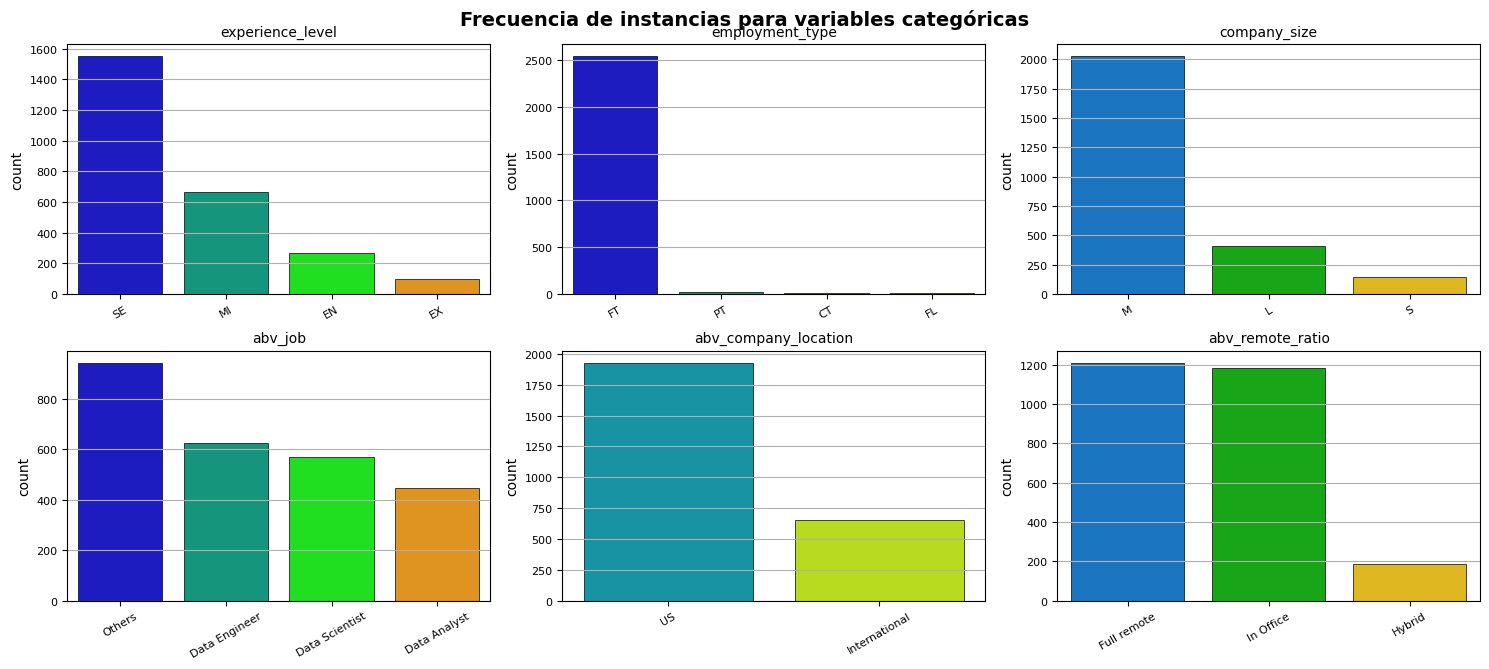

In [ ]:
#Visualización de frecuencia de instancias para variables categóricas
multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

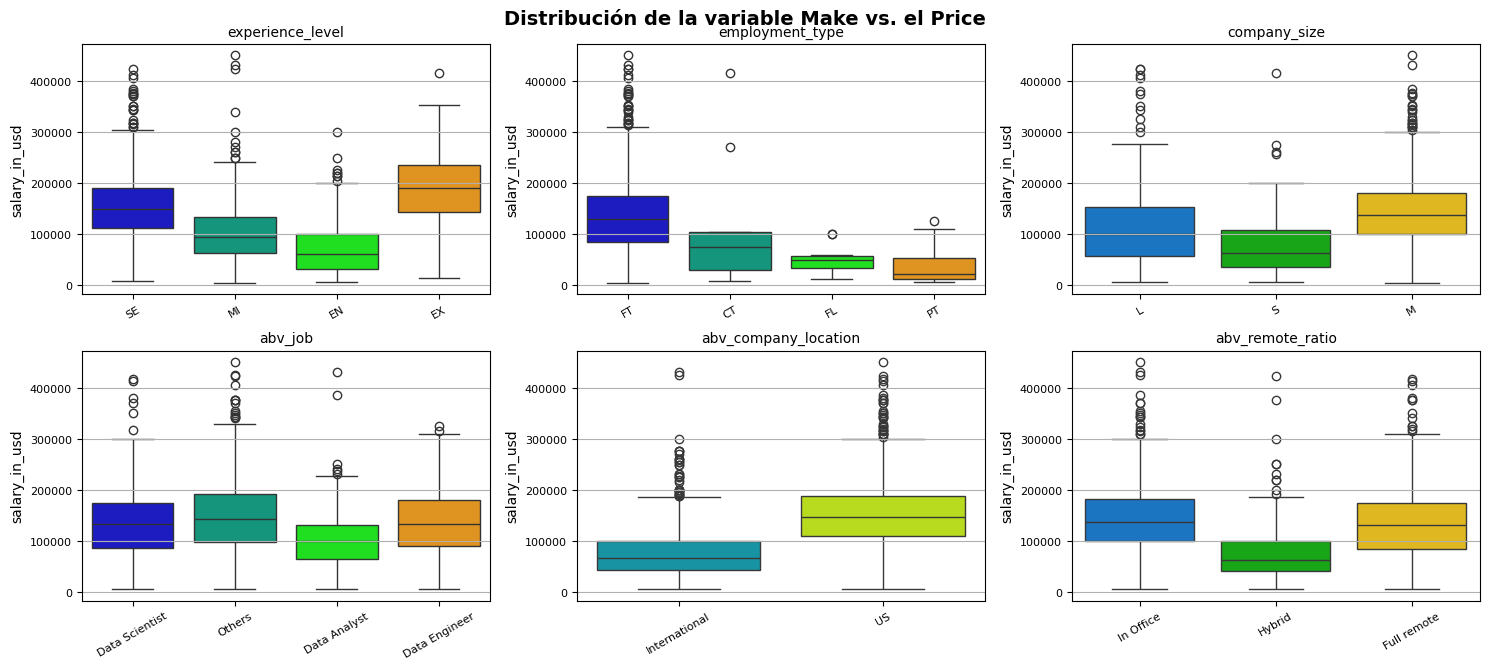

In [ ]:
multiple_plot(3, d , catCols, 'salary_in_usd', 'boxplot', 'Distribución de la variable Make vs. el Price',30)

### Identificación de Valores Nulos Categoricas y Númericas

In [ ]:
#Identificación de valores nulos para las variables categoricas
for col in d[catCols]:
    print (col, np.sum(pd.isnull(d[col])))

experience_level 0
employment_type 0
company_size 0
abv_job 0
abv_company_location 0
abv_remote_ratio 0


In [ ]:
#Identificación de valores nulos para las variables numéricas
for col in d[numCols]:
    print (col, np.sum(pd.isnull(d[col])))

salary_in_usd 0


### Valores atípicos para las variables de entrada

In [ ]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=13, contamination=0.1)

# identificar los valores atípicos por medio de lof
y_pred = lof.fit_predict(d[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', d[outliers].index.tolist())


Indices de valores atípicos:  [5, 7, 10, 14, 16, 22, 31, 32, 34, 38, 43, 45, 52, 56, 60, 61, 63, 65, 69, 82, 118, 121, 125, 132, 179, 197, 198, 252, 254, 259, 287, 289, 290, 299, 302, 307, 331, 345, 346, 358, 368, 374, 390, 393, 401, 412, 415, 421, 442, 449, 475, 480, 490, 493, 500, 510, 581, 585, 589, 603, 631, 664, 666, 733, 734, 738, 742, 743, 780, 783, 795, 810, 823, 841, 849, 850, 857, 867, 868, 872, 879, 888, 917, 922, 927, 981, 988, 990, 998, 1004, 1006, 1009, 1076, 1078, 1086, 1089, 1103, 1112, 1126, 1128, 1134, 1135, 1139, 1142, 1148, 1169, 1175, 1200, 1226, 1245, 1250, 1267, 1289, 1310, 1311, 1314, 1315, 1318, 1319, 1344, 1350, 1354, 1356, 1366, 1368, 1390, 1391, 1424, 1429, 1430, 1431, 1437, 1443, 1450, 1466, 1468, 1473, 1474, 1489, 1496, 1508, 1514, 1528, 1545, 1549, 1567, 1574, 1577, 1578, 1580, 1591, 1592, 1598, 1599, 1617, 1621, 1639, 1640, 1652, 1674, 1685, 1688, 1708, 1720, 1749, 1750, 1755, 1758, 1788, 1790, 1793, 1796, 1798, 1802, 1803, 1813, 1844, 1848, 1868, 1877, 

In [ ]:
# Eliminar los valores atípicos del dataframe original
d = d.loc[~outliers]

### Valores atípicos de la variable de salida

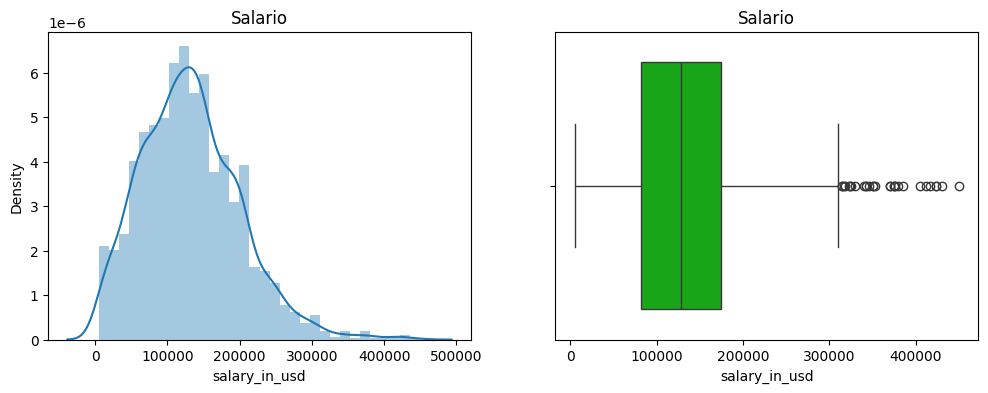

In [ ]:
#Histográma y caja de bigotes del Salario de los cargos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Salario')
sns.distplot(d['salary_in_usd'])

plt.subplot(1,2,2)
plt.title('Salario')
sns.boxplot(x=d['salary_in_usd'], palette='nipy_spectral')

plt.show()

In [ ]:
#Calculo de valores atípicos


#Calculo de Q1 t Q3
Q1 = np.percentile(d['salary_in_usd'], 25, interpolation = 'midpoint')
Q3 = np.percentile(d['salary_in_usd'], 75, interpolation = 'midpoint')

#Cálculo del rango intercuartil
IQR = Q3 - Q1

#Cálculo de valor mínimo y máximo para los valores atípicos
VAInf = Q1 - 1.5*IQR
VASup = Q3 + 1.5*IQR

print(f'Valor atípico leve inferior:{VAInf}')
print(f'Valor atípico leve superior:{VASup}')


Valor atípico leve inferior:-56587.5
Valor atípico leve superior:313952.5


In [ ]:
# Se eliminan los valores atípicos
d = d.drop(d[d['salary_in_usd']>VASup].index)

#Reiniciar el indice
d.reset_index(drop=True, inplace=True)

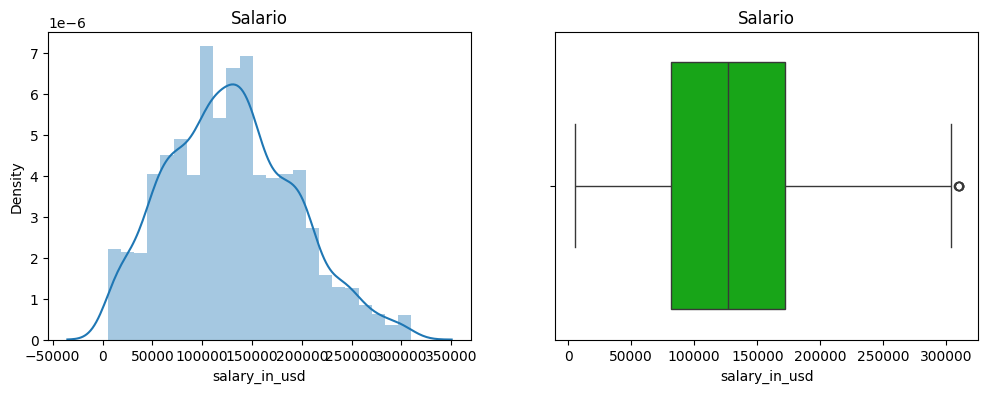

In [ ]:
#Histográma y caja de bigotes del Salario de los cargos

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Salario')
sns.distplot(d['salary_in_usd'])

plt.subplot(1,2,2)
plt.title('Salario')
sns.boxplot(x=d['salary_in_usd'], palette='nipy_spectral')

plt.show()

In [ ]:
#Descripción de los salarios después de eliminar valores atípicos

print(d['salary_in_usd'].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,0.95,0.975,1]))

count     2296.0000
mean    129270.4281
std      63288.8381
min       5132.0000
25%      81500.0000
50%     127148.0000
75%     172200.0000
85%     200000.0000
90%     210275.0000
95%     241903.2500
97.5%   261125.0000
100%    310000.0000
max     310000.0000
Name: salary_in_usd, dtype: float64


In [ ]:
df = d.copy()

In [ ]:
catCols

['experience_level',
 'employment_type',
 'company_size',
 'abv_job',
 'abv_company_location',
 'abv_remote_ratio']

In [ ]:
d.columns

Index(['experience_level', 'employment_type', 'salary_in_usd', 'company_size',
       'abv_job', 'abv_company_location', 'abv_remote_ratio'],
      dtype='object')

### Gestión de Caracteristicas categoricas y Estandarización

In [ ]:
numCols

['salary_in_usd']

In [ ]:
# Prepocesamiento del Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        #('num',, numCols),  # Scale numerical column
        ('cat', OneHotEncoder(), catCols)  # One-hot encode categorical features
    ])

# Fit-transform the preprocessing pipeline to the data
processed_data = preprocessor.fit_transform(d)

# Convert processed_data back to DataFrame
p_df = pd.DataFrame(processed_data)

# Get the original column names after preprocessing
transformed_columns = list(preprocessor.named_transformers_['cat'].get_feature_names_out(catCols))

# Assign the original column names to the processed DataFrame
p_df.columns = transformed_columns

In [ ]:
transformed_columns

['experience_level_EN',
 'experience_level_EX',
 'experience_level_MI',
 'experience_level_SE',
 'employment_type_CT',
 'employment_type_FL',
 'employment_type_FT',
 'employment_type_PT',
 'company_size_L',
 'company_size_M',
 'company_size_S',
 'abv_job_Data Analyst',
 'abv_job_Data Engineer',
 'abv_job_Data Scientist',
 'abv_job_Others',
 'abv_company_location_International',
 'abv_company_location_US',
 'abv_remote_ratio_Full remote',
 'abv_remote_ratio_Hybrid',
 'abv_remote_ratio_In Office']

In [ ]:
p_df

,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,company_size_L,company_size_M,company_size_S,abv_job_Data Analyst,abv_job_Data Engineer,abv_job_Data Scientist,abv_job_Others,abv_company_location_International,abv_company_location_US,abv_remote_ratio_Full remote,abv_remote_ratio_Hybrid,abv_remote_ratio_In Office
0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
1,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000
2292,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2293,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2294,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,0.0000


In [ ]:
d['salary_in_usd']

0        85847
1        30000
2        25500
3       175000
4       120000
         ...  
2291     28369
2292    165000
2293    151000
2294    105000
2295    100000
Name: salary_in_usd, Length: 2296, dtype: int64

In [ ]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   experience_level_EN                 2296 non-null   float64
 1   experience_level_EX                 2296 non-null   float64
 2   experience_level_MI                 2296 non-null   float64
 3   experience_level_SE                 2296 non-null   float64
 4   employment_type_CT                  2296 non-null   float64
 5   employment_type_FL                  2296 non-null   float64
 6   employment_type_FT                  2296 non-null   float64
 7   employment_type_PT                  2296 non-null   float64
 8   company_size_L                      2296 non-null   float64
 9   company_size_M                      2296 non-null   float64
 10  company_size_S                      2296 non-null   float64
 11  abv_job_Data Analyst                2296 no

In [ ]:
p_df.head()

,experience_level_EN,experience_level_EX,experience_level_MI,experience_level_SE,employment_type_CT,employment_type_FL,employment_type_FT,employment_type_PT,company_size_L,company_size_M,company_size_S,abv_job_Data Analyst,abv_job_Data Engineer,abv_job_Data Scientist,abv_job_Others,abv_company_location_International,abv_company_location_US,abv_remote_ratio_Full remote,abv_remote_ratio_Hybrid,abv_remote_ratio_In Office
0,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
1,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
2,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,1.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000


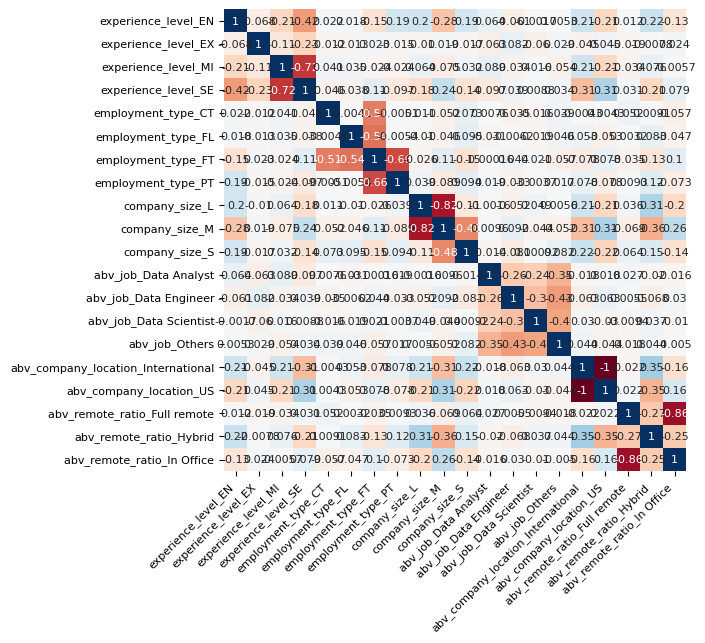

In [ ]:
# Mapa de calor (Heatmap) de la matriz de correlaciones
matrizCorr = p_df.corr()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.heatmap(
    matrizCorr,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 8},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = 'RdBu', #sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)

In [ ]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296 entries, 0 to 2295
Data columns (total 20 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   experience_level_EN                 2296 non-null   float64
 1   experience_level_EX                 2296 non-null   float64
 2   experience_level_MI                 2296 non-null   float64
 3   experience_level_SE                 2296 non-null   float64
 4   employment_type_CT                  2296 non-null   float64
 5   employment_type_FL                  2296 non-null   float64
 6   employment_type_FT                  2296 non-null   float64
 7   employment_type_PT                  2296 non-null   float64
 8   company_size_L                      2296 non-null   float64
 9   company_size_M                      2296 non-null   float64
 10  company_size_S                      2296 non-null   float64
 11  abv_job_Data Analyst                2296 no

In [ ]:
#Matriz de correlación ordenada

pd.set_option('display.float_format', lambda x: '%.4f' % x)

#Creación de la matriz
df_corr= tidy_corr_matrix(matrizCorr)

#Selección de las variables correlacionadas con el salario
df_filtrado = df_corr.loc[df_corr['variable_2'] == 'salary_in_usd']

#Se identifican las correlaciones más fuertes
df_filtrado[df_filtrado['abs_r']>=0.4]

,variable_1,variable_2,r,abs_r


In [ ]:
#Cantidad de variables más relevantes extraidas a partir de la matriz de correlación ordenada
VarRelevantes = df_filtrado[df_filtrado['abs_r']>=0.5].shape[0]

#Creacion de la lista de variables más relevantes (inicialmente numéricas)
vDep =df_filtrado['variable_1'][:VarRelevantes].tolist()
print(vDep)

[]


### Creación del Modelo

In [ ]:
# Dividir el DataFrame en características (X) y variable de destino (y)
X = p_df
y = d['salary_in_usd']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(
#                                         X,
#                                         y.values.reshape(-1,1),
#                                         train_size   = 0.7,
#                                         random_state = 42,
#                                         shuffle      = True # Realiza mezcla del modelo
#                                     )

In [ ]:
# Dividir el DataFrame en características (X) y variable de destino (y)
X = p_df
y = d['salary_in_usd']

# Dividir la data en entrenamiento(70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle= True)

# Inicializar el modelo de regresion lineal
model = LinearRegression()

# Ajustar el modelo a los datos de entrenamiento.
model.fit(X_train, y_train)

# Predicciones en el set de prueba.
y_train_pred = model.predict(X_train)

# Predicciones en el set de prueba.
y_test_pred = model.predict(X_test)


In [ ]:
# Error de Entrenamiento del modelo

print("=============== Errores de Valuación Train ===================")
mse = mean_squared_error (y_true  = y_train, y_pred  = y_train_pred, squared = True)
rmse = mean_squared_error (y_true  = y_train, y_pred  = y_train_pred, squared = False)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = y_train_pred)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = y_train_pred)
r2 = r2_score (y_true  = y_train, y_pred  = y_train_pred)

print(f"El error MSE   de train es: {mse}")
print(f"El error RMSE  de train es: {rmse}")
print(f"El error MAE   de train es: {MAE}")
print(f"El error MedAE de train es: {MedAE}")
print(f"El error R2    de train es: {r2}")

print("=============== Errores de Valuación Test ===================")
# Calcular los errores de evaluación
mse = mean_squared_error(y_test, y_test_pred)
rmse = mean_squared_error(y_test, y_test_pred, squared=False)
mae = mean_absolute_error(y_test, y_test_pred)
medae = median_absolute_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Mostrar los resultados
print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {mae}")
print(f"El error MedAE de test es: {medae}")
print(f"El error R2    de test es: {r2}")

=============== Errores de Valuación Train ===================
El error MSE   de train es: 2290989988.8061004
El error RMSE  de train es: 47864.28719626043
El error MAE   de train es: 37386.88017429194
El error MedAE de train es: 30490.0
El error R2    de train es: 0.4209764513876849
=============== Errores de Valuación Test ===================
El error MSE   de test es: 2244952099.0369563
El error RMSE  de test es: 47380.925476788194
El error MAE   de test es: 37728.4152173913
El error MedAE de test es: 30840.0
El error R2    de test es: 0.46196804043543926


- El error MSE   de test es: 0.6062388662808946 -> En promedio, las predicciones del modelo difieren de los valores reales en aproximadamente 0.6062 unidades al cuadrado.
- El error RMSE  de test es: 0.7786134254435217 -> En promedio, las predicciones del modelo difieren de los valores reales en aproximadamente 0.7786 unidades.
- El error MAE   de test es: 0.6185968564907902 -> En promedio, las predicciones del modelo difieren de los valores reales en aproximadamente 0.6186 unidades.
- El error MedAE de test es: 0.5253333989191555 -> Indica que el 50% de los errores absolutos son menores o iguales a 0.5253
- El error R2    de test es: 0.39757354599832595 -> Indica que el modelo explica aproximadamente el 39.76% de la variabilidad en la variable objetivo


MSE, RMSE, MAE y MedAE son valores relativamente altos en los errores de evaluación, lo que da a deducir que el modelo no puede predecir con presición los valores relacionados a salario en el conjunto de prueba. Solo en un 39% el modelo explica la variabilidad de los datos con respecto al salario.  

### Modelo de regresion Random Forest

In [ ]:
# Inicilizarl el modelo fde regresion Random Forest
rf_model = RandomForestRegressor(random_state=42)

# # Ajustar el modelo a los datos de entrenamiento.
rf_model.fit(X_train, y_train)

# Predicciones en el set de prueba
y_valid_pred_rf = rf_model.predict(X_test)

# Calculate the mean squared error on the validation set
mse_valid_rf = mean_squared_error(y_test, y_valid_pred_rf)
print("Mean Squared Error on Validation Set (Random Forest):", mse_valid_rf)

# Predictions on the test set
y_train_pred_rf = rf_model.predict(X_train)

# Predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Calculate the mean squared error on the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
print("Mean Squared Error on Test Set (Random Forest):", mse_test_rf)

Mean Squared Error on Validation Set (Random Forest): 2418022776.7543907
Mean Squared Error on Test Set (Random Forest): 2418022776.7543907


In [ ]:
# Error de Entrenamiento del modelo - Random Forest
print("=============== Errores de Valuación Train ===================")
mse = mean_squared_error (y_true  = y_train, y_pred  = y_train_pred_rf, squared = True)
rmse = mean_squared_error (y_true  = y_train, y_pred  = y_train_pred_rf, squared = False)
MAE = mean_absolute_error (y_true  = y_train, y_pred  = y_train_pred_rf)
MedAE = median_absolute_error (y_true  = y_train, y_pred  = y_train_pred_rf)
r2 = r2_score (y_true  = y_train, y_pred  = y_train_pred_rf)

print(f"El error MSE   de train es: {mse}")
print(f"El error RMSE  de train es: {rmse}")
print(f"El error MAE   de train es: {MAE}")
print(f"El error MedAE de train es: {MedAE}")
print(f"El error R2    de train es: {r2}")

print("=============== Errores de Valuación Test ===================")

# Calcular los errores de evaluación
mse = mean_squared_error(y_test, y_test_pred_rf)
rmse = mean_squared_error(y_test, y_test_pred_rf, squared=False)
mae = mean_absolute_error(y_test, y_test_pred_rf)
medae = median_absolute_error(y_test, y_test_pred_rf)
r2 = r2_score(y_test, y_test_pred_rf)

# Mostrar los resultados
print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {mae}")
print(f"El error MedAE de test es: {medae}")
print(f"El error R2    de test es: {r2}")

=============== Errores de Valuación Train ===================
El error MSE   de train es: 2001537295.6216009
El error RMSE  de train es: 44738.54373604041
El error MAE   de train es: 34393.598315608346
El error MedAE de train es: 27376.157883843618
El error R2    de train es: 0.49413256572340125
=============== Errores de Valuación Test ===================
El error MSE   de test es: 2418022776.7543907
El error RMSE  de test es: 49173.395009439715
El error MAE   de test es: 38753.55805903743
El error MedAE de test es: 30312.1787735002
El error R2    de test es: 0.42048940224292575


### Diagnostico de residuos

In [ ]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor


# Definir el modelo GradientBoosting
modelGrdB = GradientBoostingRegressor()

CV = 10

# Definir los parámetros a ajustar y sus posibles valores
parameters = {
    'n_estimators': [ 20, 25, 30, 35, 40],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [5, 10, 15, 20, 40]
}

grid_GrdB = GridSearchCV(
        estimator  = modelGrdB,
        param_grid = parameters,
        n_jobs     = - 1,
        cv         = CV,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GrdB.fit(X = X, y = y)

GridSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [5, 10, 15, 20, 40],
                         'n_estimators': [20, 25, 30, 35, 40]},
             return_train_score=True)

In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_GrdB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
2,0.1000,5,30,0.3796,0.0929,0.4738,0.0144
3,0.1000,5,35,0.3790,0.0937,0.4781,0.0150
1,0.1000,5,25,0.3790,0.0931,0.4680,0.0142
4,0.1000,5,40,0.3768,0.0939,0.4810,0.0151


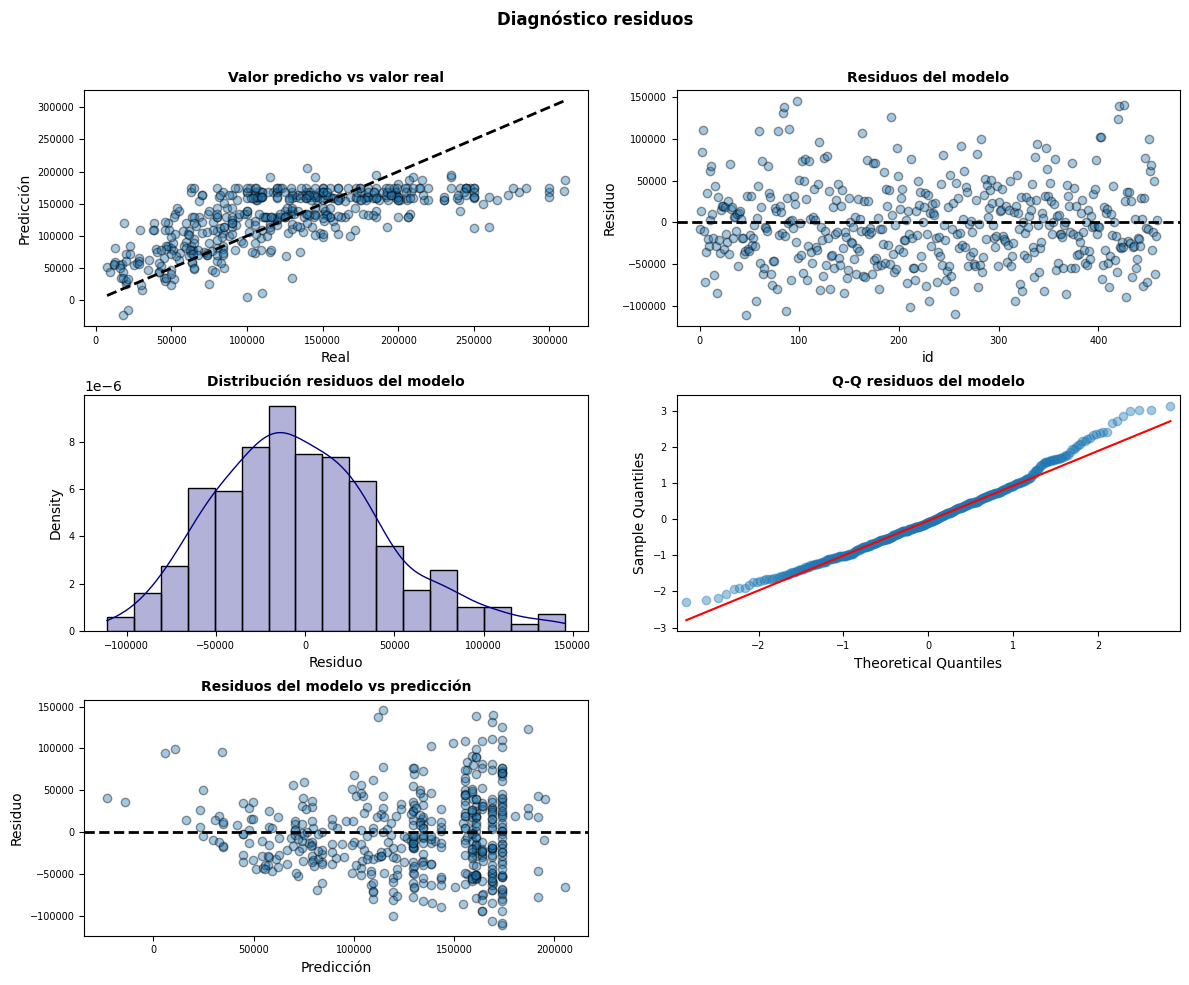

In [ ]:
# Calcular los residuos
residuos_test = y_test - y_test_pred

# Gráficos para el pronóstico de residuos
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

# Gráfico de valor predicho vs valor real
axes[0, 0].scatter(y_test, y_test_pred, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize=10, fontweight="bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize=7)

# Gráfico de residuos del modelo
axes[0, 1].scatter(list(range(len(y_test))), residuos_test, edgecolors=(0, 0, 0), alpha=0.4)
axes[0, 1].axhline(y=0, linestyle='--', color='black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize=10, fontweight="bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize=7)

# Gráfico de distribución de residuos del modelo
sns.histplot(
    data=residuos_test,
    stat="density",
    kde=True,
    line_kws={'linewidth': 1},
    color="navy",
    alpha=0.3,
    ax=axes[1, 0]
)
axes[1, 0].set_title('Distribución residuos del modelo', fontsize=10, fontweight="bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize=7)

# Gráfico Q-Q de residuos del modelo
sm.qqplot(
    residuos_test,
    fit=True,
    line='q',
    ax=axes[1, 1],
    color='navy',
    alpha=0.4,
    lw=2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize=10, fontweight="bold")
axes[1, 1].tick_params(labelsize=7)

# Gráfico de residuos del modelo vs predicción
axes[2, 0].scatter(y_test_pred, residuos_test, edgecolors=(0, 0, 0), alpha=0.4)
axes[2, 0].axhline(y=0, linestyle='--', color='black', lw=2)
axes[2, 0].set_title('Residuos del modelo vs predicción', fontsize=10, fontweight="bold")
axes[2, 0].set_xlabel('Predicción')
axes[2, 0].set_ylabel('Residuo')
axes[2, 0].tick_params(labelsize=7)

# Se eliminan los axes vacíos
fig.delaxes(axes[2, 1])

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize=12, fontweight="bold")

plt.show()


## Conclusiones

Los errores cuadráticos medios en los dos modelos son altos, lo que señala una discrepancia considerable entre los salarios reales y los predichos. Además, los valores bajos de linealidad (r²) indican una asociación débil entre los valores predichos y reales.

Ninguno de los modelos dio una gran presición en la predicción salarial, sin embargo el modelo de regresion presento un rendimiento ligeramente mejor.

Es necesario tener una muestra amplia con una amplia gama de factores que afecten los salarios y realizar una mejor prediccion de estos teniendo diferentes contextos.